GA - Sphere
  Best Value : 0.000303
  Avg Value  : 0.000772
  Avg Time   : 12.11 seconds

GA - Rastrigin
  Best Value : 0.089022
  Avg Value  : 0.552228
  Avg Time   : 12.80 seconds

PSO - Sphere
  Best Value : 0.000000
  Avg Value  : 0.000000
  Avg Time   : 1.00 seconds

PSO - Rastrigin
  Best Value : 3.979836
  Avg Value  : 6.777838
  Avg Time   : 1.47 seconds



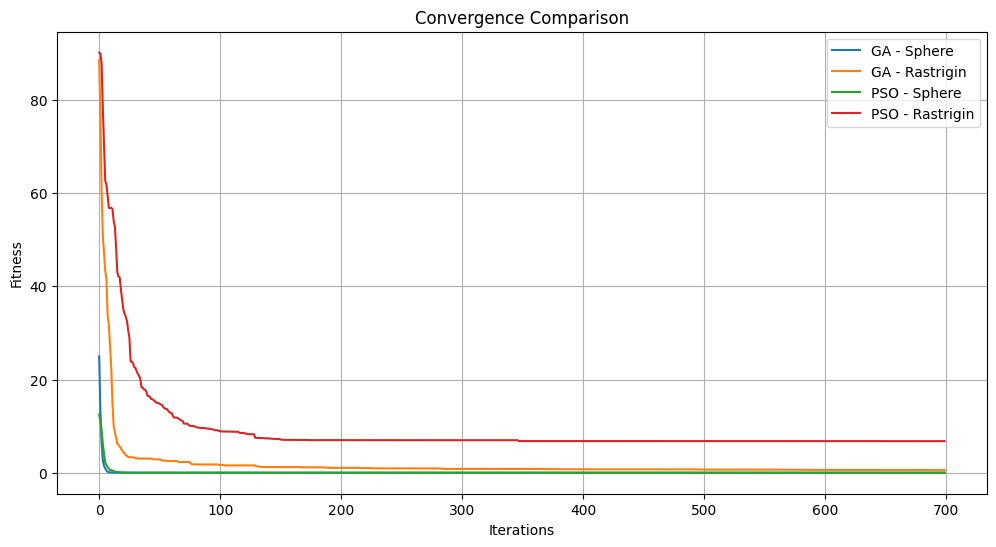

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Benchmark Functions
def sphere(x):
    return np.sum(x**2)

def rastrigin(x):
    return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))

# Genetic Algorithm
def run_ga(function, dim, pop_size, generations, crossover_rate, mutation_rate, bounds):
    def initialize_population():
        return np.random.uniform(bounds[0], bounds[1], (pop_size, dim))

    def evaluate(pop):
        return np.array([function(ind) for ind in pop])

    def select(pop, fit):
        i, j = np.random.choice(len(pop), 2, replace=False)
        return pop[i] if fit[i] < fit[j] else pop[j]

    def crossover(p1, p2):
        alpha = np.random.rand(dim)
        return alpha * p1 + (1 - alpha) * p2

    def mutate(ind):
        if np.random.rand() < mutation_rate:
            ind += np.random.normal(0, 0.1, size=ind.shape)
        return np.clip(ind, bounds[0], bounds[1])

    population = initialize_population()
    best_values = []
    best_solution = None
    best_value = float("inf")
    start_time = time.time()

    for gen in range(generations):
        fitness = evaluate(population)
        if np.min(fitness) < best_value:
            best_value = np.min(fitness)
            best_solution = population[np.argmin(fitness)]

        best_values.append(best_value)

        new_population = []
        while len(new_population) < pop_size:
            p1 = select(population, fitness)
            p2 = select(population, fitness)
            child = crossover(p1, p2)
            child = mutate(child)
            new_population.append(child)
        population = np.array(new_population)

    run_time = time.time() - start_time
    return best_solution, best_value, best_values, run_time

# Particle Swarm Optimization
def run_pso(function, dim, swarm_size, iterations, w, c1, c2, bounds):
    position = np.random.uniform(bounds[0], bounds[1], (swarm_size, dim))
    velocity = np.zeros_like(position)
    personal_best = position.copy()
    personal_best_value = np.array([function(p) for p in personal_best])
    global_best = personal_best[np.argmin(personal_best_value)]
    global_best_value = np.min(personal_best_value)
    best_values = []
    start_time = time.time()

    for t in range(iterations):
        r1, r2 = np.random.rand(dim), np.random.rand(dim)
        velocity = w * velocity + c1 * r1 * (personal_best - position) + c2 * r2 * (global_best - position)
        position += velocity
        position = np.clip(position, bounds[0], bounds[1])
        values = np.array([function(p) for p in position])

        for i in range(swarm_size):
            if values[i] < personal_best_value[i]:
                personal_best[i] = position[i]
                personal_best_value[i] = values[i]

        if np.min(personal_best_value) < global_best_value:
            global_best = personal_best[np.argmin(personal_best_value)]
            global_best_value = np.min(personal_best_value)

        best_values.append(global_best_value)

    run_time = time.time() - start_time
    return global_best, global_best_value, best_values, run_time

# Run each config 5 times
def run_multiple(func, runner, name, params):
    best_vals, times, all_convergence = [], [], []
    for _ in range(5):
        sol, val, fit, t = runner(func, **params)
        best_vals.append(val)
        times.append(t)
        all_convergence.append(fit)

    avg_vals = np.mean(best_vals)
    best_val = np.min(best_vals)
    avg_time = np.mean(times)
    print(f"{name}")
    print(f"  Best Value : {best_val:.6f}")
    print(f"  Avg Value  : {avg_vals:.6f}")
    print(f"  Avg Time   : {avg_time:.2f} seconds\n")

    # Plot average convergence
    avg_curve = np.mean(np.array([np.pad(f, (0, max(map(len, all_convergence))-len(f)), 'edge') for f in all_convergence]), axis=0)
    return name, avg_curve

# Parameters
ga_params = {
    "dim": 10,
    "pop_size": 250,
    "generations": 700,
    "crossover_rate": 0.9,
    "mutation_rate": 0.05,
    "bounds": (-5.12, 5.12)
}
pso_params = {
    "dim": 10,
    "swarm_size": 250,
    "iterations": 700,
    "w": 0.6,
    "c1": 1.5,
    "c2": 1.5,
    "bounds": (-5.12, 5.12)
}

# Run All
plots = []
plots.append(run_multiple(sphere, run_ga, "GA - Sphere", ga_params))
plots.append(run_multiple(rastrigin, run_ga, "GA - Rastrigin", ga_params))
plots.append(run_multiple(sphere, run_pso, "PSO - Sphere", pso_params))
plots.append(run_multiple(rastrigin, run_pso, "PSO - Rastrigin", pso_params))

# Convergence Plot
plt.figure(figsize=(12, 6))
for name, curve in plots:
    plt.plot(curve, label=name)
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.title("Convergence Comparison")
plt.grid(True)
plt.legend()
plt.show()
